In [2]:
from io import StringIO
import json
import warnings

# import earthaccess
import gdown
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import streamlit as st
from tqdm import tqdm
import xarray as xr
import xgboost as xgb

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

## Initial Data Exploration - Scalloped Hammerhead Shark
This notebook does the following:
- Loads in the scalloped hammerhead shark data downloaded from [GBIF](https://www.gbif.org/occurrence/download?taxon_key=2418789)
- Defines the accessible area for the shark based on visualisation and general scientific understanding

### 1. Raw Species Data

#### 1.1  Download and Process Presence Data
- Stored all data in a public Google Drive link for ease

In [ ]:
url = "https://drive.google.com/drive/folders/10PrHepxwE45PAGGKIFgTfXlLrJ52NFwy?usp=drive_link"
gdown.download_folder(url, output="../", quiet=False, use_cookies=False)

In [14]:
def load_raw_presence_data(filepath):
    df = pd.read_csv(filepath, sep='\t', on_bad_lines="skip")
    print(f"Species Counts: {df['species'].nunique()}")
    print(f"Initial number of rows: {df.shape[0]}")
    return df

def filter_basic_issues_from_dataset(df, coord_uncertainty_threshold=500, remove_uncertainty_nans=True):
    # Note - may want to be more lenient here depending on how dynamic the env variables are at short distances
    num_to_remove = ((df["coordinateUncertaintyInMeters"] >= coord_uncertainty_threshold)).sum()
    df = df[(df["coordinateUncertaintyInMeters"] < coord_uncertainty_threshold) |
            (df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on coordinate uncertainty, leaving {df.shape[0]} rows")
    
    if remove_uncertainty_nans:
        num_to_remove = (df["coordinateUncertaintyInMeters"].isna()).sum()
        df = df[~(df["coordinateUncertaintyInMeters"].isna())].reset_index(drop=True)
        print(f"Filtered out {num_to_remove} rows based on missing coordinate uncertainty, leaving {df.shape[0]} rows")
    
    # Remove rows with no lat/lon
    num_to_remove = (df["decimalLatitude"].isna() | df["decimalLongitude"].isna()).sum()
    df = df[~(df["decimalLatitude"].isna()) & ~(df["decimalLongitude"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on missing lat/lon, leaving {df.shape[0]} rows")
    df = df.rename(columns={"decimalLatitude": "latitude", "decimalLongitude": "longitude"})
    
    # Remove rows with invalid dates
    df["date"] = pd.to_datetime(df[["year", "month", "day"]], errors='coerce')
    num_to_remove = (df["date"].isna()).sum()
    df = df[~(df["date"].isna())].reset_index(drop=True)
    print(f"Filtered out {num_to_remove} rows based on invalid dates, leaving {df.shape[0]} rows")

    # Remove those too old to use recent satellite data
    num_to_remove = (df["date"] <= pd.Timestamp("2002-01-01")).sum()
    df = df[df["date"] > pd.Timestamp("2002-01-01")]
    print(f"Filtered out {num_to_remove} rows based on being too old, leaving {df.shape[0]} rows")
    return df

In [15]:
presence_df = load_raw_presence_data('../data/gbif/scalloped_hammerhead.csv')
presence_df = filter_basic_issues_from_dataset(presence_df, coord_uncertainty_threshold=500, remove_uncertainty_nans=False)
presence_df = presence_df[[
    "latitude",
    "longitude",
    "date"
]]
presence_gdf = gpd.GeoDataFrame(
    presence_df,
    geometry=gpd.points_from_xy(presence_df.longitude, presence_df.latitude),
    crs="EPSG:4326"  # Latitude, longitude, in degrees
)

Species Counts: 1
Initial number of rows: 28365
Filtered out 3001 rows based on coordinate uncertainty, leaving 25364 rows
Filtered out 1661 rows based on missing lat/lon, leaving 23703 rows
Filtered out 985 rows based on invalid dates, leaving 22718 rows
Filtered out 4642 rows based on being too old, leaving 18076 rows


#### 1.2 Initial Visualization
- Helps to define appropiate accessible area
- Load in coastline data as map overlay
- Longitude actually is the entire range (-180, 180)
- Latitude does have some limits
- Could be worth limiting our search initially to one continent, to start with. E.g. many points in North America.

In [16]:
coastline = gpd.read_file("../data/environmental/ne_10m_coastline/ne_10m_coastline.shp")

In [17]:
padding=2.0
max_lon = presence_gdf["longitude"].max() + padding
min_lon = presence_gdf["longitude"].min() - padding
max_lat = presence_gdf["latitude"].max() + padding
min_lat = presence_gdf["latitude"].min() - padding

# Correction
max_lon = 180
min_lon = -180

In [18]:
def visualise_data_on_map(coastline, points_dfs=[], points_dfs_colors=[], points_dfs_labels=[], coastline_alpha=1, 
                          plot_bounding_box=True, limit_to_bounding_box=False, accessible_area=None, show_plot=True):
    coastline = coastline.to_crs(epsg=4326)
    coastline.plot(color="black", linewidth=0.5, figsize=(20,10), label="Coastline", alpha=coastline_alpha)
    for i, points_df in enumerate(points_dfs):
        plt.scatter(points_df["longitude"], points_df["latitude"], s=5, label=points_dfs_labels[i], color=points_dfs_colors[i])

    if plot_bounding_box:
        plt.plot([min_lon, min_lon, max_lon, max_lon, min_lon],
                [min_lat, max_lat, max_lat, min_lat, min_lat], color='blue', alpha=0.5, linewidth=1, label="Accessible Area")
        
    if accessible_area is not None:
        accessible_area.plot(
            cmap="Blues",
            alpha=0.4,
            add_colorbar=False,
            label="Accessible Area"
        )
        
    if limit_to_bounding_box:
        plt.xlim(min_lon - 2, max_lon + 2)
        plt.ylim(min_lat - 2, max_lat + 2)

    plt.axis('off')
    if show_plot:
        plt.legend()
        plt.show()

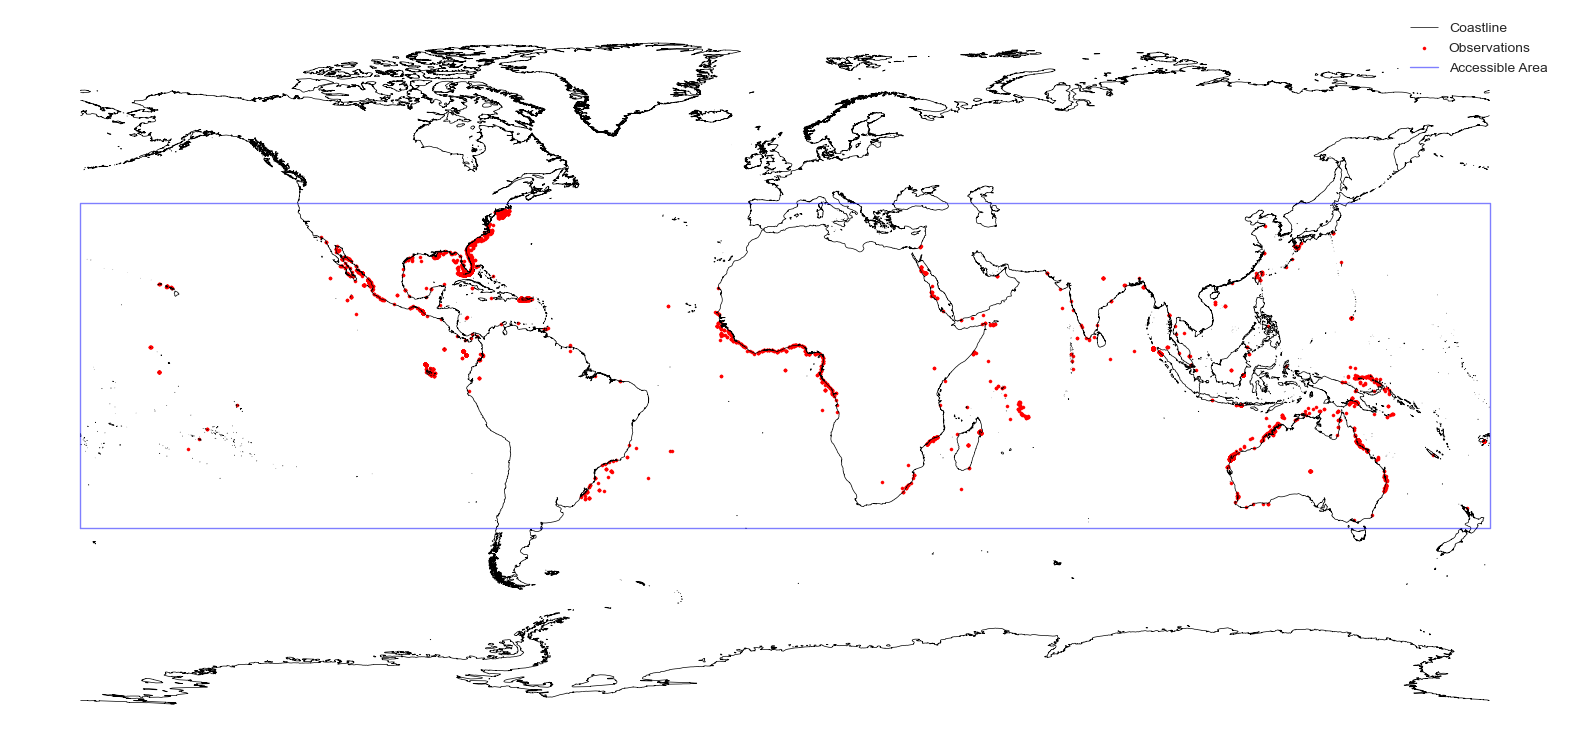

In [39]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"])

### 3. Accessible Area Creation
Using the map and also [this source](https://www.fishbase.se/summary/912) we filter to the following accessible area to begin with:
- No land
- Latitude -39 to 46
- Longitude -180 to 180
- If we want to be more specific, we can filter to the distribution areas found in the fishbase source above.
- Another consideration: Depth 0 to 1043m - typically 0-25m. However, we can't filter the area based on bathymetry because the shark isn't only at the bottom, it can be anywhere on the depth axis.

We will use this to:
- Filter presence data to be within this area only
- Sample appropriate background data

In [19]:
MIN_LAT = -39
MAX_LAT = 46

In [20]:
def create_accessible_area(ref_coordinate_space_dataset_path="../data/environmental/bio_oracle/bathymetry.nc"):
    """
    Criteria:
    - -39 to 36 longitude
    - No land
    """
    ds = xr.open_dataset(ref_coordinate_space_dataset_path)
    bathy = ds["bathymetry_mean"]

    lons = bathy["longitude"].values
    lats = bathy["latitude"].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    region_mask = (
        (lat2d >= MIN_LAT) & (lat2d <= MAX_LAT)
    )

    ocean_mask = np.isfinite(bathy.values)[0]
    accessible_area_mask = ocean_mask & region_mask

    accessible_area = xr.DataArray(
        accessible_area_mask.astype(np.uint8),
        coords={"latitude": bathy["latitude"], "longitude": bathy["longitude"]},
        dims=("latitude", "longitude"),
        name="M_accessible"
    )
    return accessible_area_mask, accessible_area

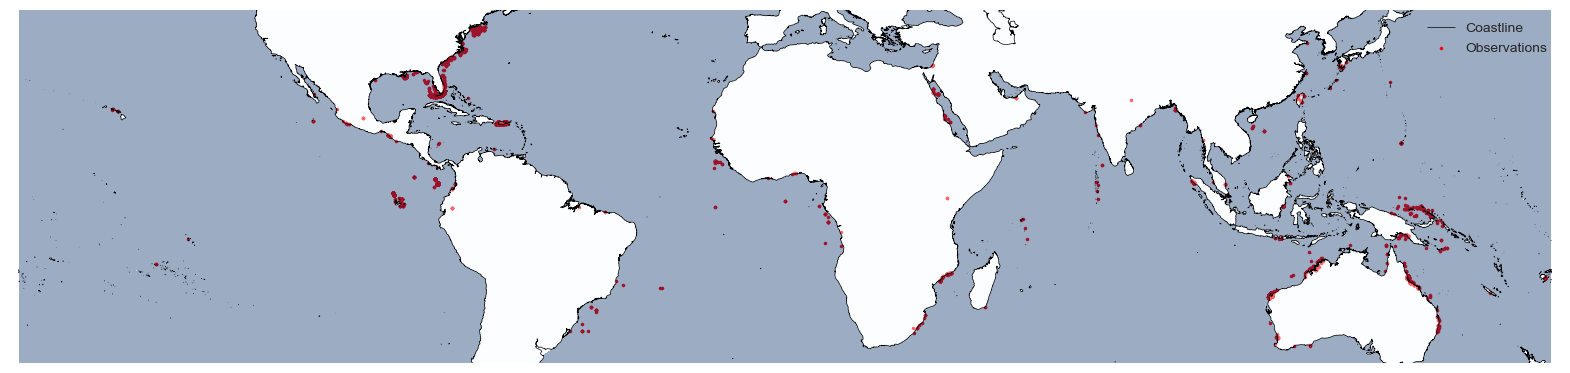

In [21]:
accessible_area_mask, accessible_area = create_accessible_area()
lons = accessible_area["longitude"].values
lats = accessible_area["latitude"].values
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"], accessible_area=accessible_area,
                      plot_bounding_box=False, limit_to_bounding_box=True)

### 3. Filter Presence Data
- Ensure it is within the accessible area only. This will remove those on land or outside the known latitudinal range.
- TODO: seems like way more is removed than I expected. One of three things:
  - The lack of granularity in bathymetry dataset cooredinates is linking many close-to-shore observations as on-shore 
  - People have classed their observations as shore-based instead of sea-based, but only just
  - There are undefined bathymetry values in the sea, i.e. I can't assume undefined <-> on land

In [22]:
def filter_data_to_be_within_accessible_area(gdf):
    gdf = gdf.to_crs(epsg=4326)
    gdf_filtered = gdf[
        gdf.geometry.apply(lambda point: accessible_area.sel(longitude=point.x, latitude=point.y, method="nearest").values == 1)
    ].reset_index(drop=True)
    gdf_removed = gdf[~gdf.index.isin(gdf_filtered.index)].reset_index(drop=True)
    n_removed = gdf.shape[0] - gdf_filtered.shape[0]
    print(f"Filtered out {n_removed} rows based on accessible area, leaving {gdf_filtered.shape[0]} rows")
    return gdf_filtered, gdf_removed

Filtered out 1662 rows based on accessible area, leaving 16414 rows


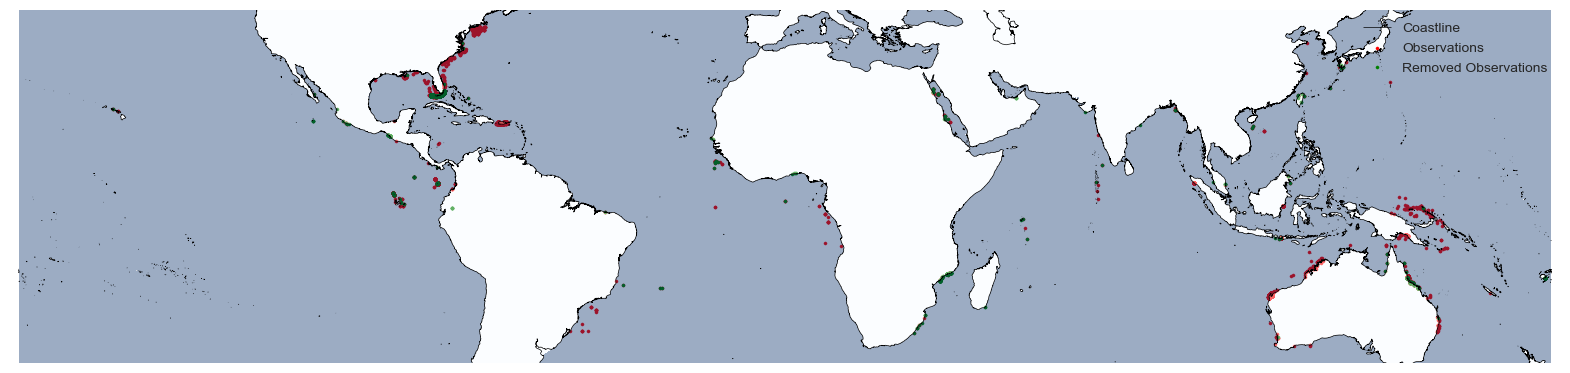

In [23]:
presence_gdf_filtered, presence_gdf_removed = filter_data_to_be_within_accessible_area(presence_gdf)

# Plotting removed points also to see if I didn't capture some important areas/variables
visualise_data_on_map(coastline, [presence_gdf_filtered, presence_gdf_removed], ["red", "green"], ["Observations", "Removed Observations"],
                      accessible_area=accessible_area, plot_bounding_box=False, limit_to_bounding_box=True)

### 4. Load Background Data
- Using [this dataset](https://www.gbif.org/occurrence/download?taxon_key=121) which consists of all Elasmobranchii (this includes sharks, rays, some fishes)
- For each month and year, build a sampling effort surface to sample points based on probabilities.

TODO: Maybe remove data points where scalloped sharks were observed nearby. Maybe do this on a monthly basis.

In [24]:
background_df = load_raw_presence_data('../data/gbif/background_data.csv')
background_df = filter_basic_issues_from_dataset(background_df)
background_gdf = gpd.GeoDataFrame(
    background_df,
    geometry=gpd.points_from_xy(background_df.longitude, background_df.latitude),
    crs="EPSG:4326"
)
background_df, _ = filter_data_to_be_within_accessible_area(background_gdf)

Species Counts: 2663
Initial number of rows: 5041602
Filtered out 1272188 rows based on coordinate uncertainty, leaving 3769414 rows
Filtered out 1940107 rows based on missing coordinate uncertainty, leaving 1829307 rows
Filtered out 4747 rows based on missing lat/lon, leaving 1824560 rows
Filtered out 23046 rows based on invalid dates, leaving 1801514 rows
Filtered out 237792 rows based on being too old, leaving 1563722 rows
Filtered out 534563 rows based on accessible area, leaving 1029159 rows


In [25]:
def create_raw_raster(gdf, accessible_area):
    raster = np.zeros_like(accessible_area, dtype=int)
    lons = accessible_area["longitude"].values
    lats = accessible_area["latitude"].values
    for lon, lat in zip(gdf["longitude"], gdf["latitude"]):
        lon_idx = np.abs(lons - lon).argmin()
        lat_idx = np.abs(lats - lat).argmin()
        if accessible_area.sel(longitude=lon, latitude=lat, method="nearest").values == 0:
            continue
        raster[lat_idx, lon_idx] += 1
    # Expect large number in a hotspot, median of 0 as most points are empty, but still a decently large amount of non-zero points
    # print(f"Raster stats - max: {raster.max()}, median: {np.median(raster)}, non-zero count: {(raster > 0).sum()}")
    return raster


def create_probability_raster(raw_raster, sigma=1):
    prob_raster = gaussian_filter(raw_raster.astype(float), sigma=sigma)
    prob_raster /= prob_raster.sum()
    return prob_raster

In [26]:
background_rasters = {}
for year in tqdm(range(2003, 2024)):
    for month in range(1, 13):
        year_month_gdf = background_gdf[(background_gdf["date"].dt.year == year) & (background_gdf["date"].dt.month == month)]
        raw_raster = create_raw_raster(year_month_gdf, accessible_area)
        prob_raster = create_probability_raster(raw_raster, sigma=1)
        background_rasters[(year, month)] = prob_raster

100%|██████████| 21/21 [06:34<00:00, 18.80s/it]


### 5. Spatial Thinning
- Thin out points close together to further remove sampling effort bias
- Try thinning out so observations fall across fewer unique days. This will help with environmental variable downloads, which take a long time to download at daily cadence.

- TODO: think of a better way to calculate distance metric to account for earth curvature.
- TODO 2: Maybe only spatially thin on a monthly basis instead of not taking temporal info into account.

In [27]:
def spatially_thin(gdf, min_distance_m):
    '''
    Spatially thin a dataset so that no points are within min_distance_m of each other.
    Reduces sampling bias for the 'presence' data.
    '''
    gdf = gdf.to_crs(epsg=3857)
    coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
    
    tree = cKDTree(coords)
    to_keep = np.ones(len(gdf), dtype=bool)
    for i in range(len(coords)):
        if to_keep[i]:
            neighbors = tree.query_ball_point(coords[i], r=min_distance_m)
            neighbors.remove(i)
            to_keep[neighbors] = False
    return gdf[to_keep].reset_index(drop=True)

presence_gdf_filtered = spatially_thin(presence_gdf_filtered, 1000).reset_index(drop=True)
print(f"Rows: {presence_gdf_filtered.shape[0]}")

Rows: 1982


### 6. Pick Background Points
- For every presence data point with associated time t, sample k background points for the relevant sampling effort surface map for that year/month.

In [28]:
BG_SIZE_PER_PRESENCE_SAMPLE = 10

1982it [07:58,  4.14it/s] 


Total background points sampled: 18580


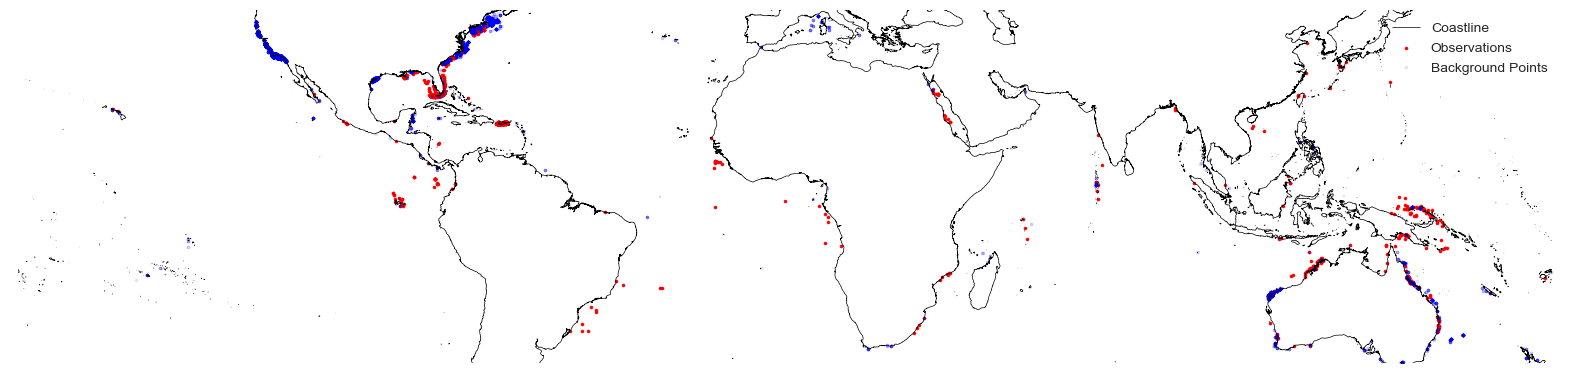

In [30]:
all_background_points = []
background_dates = []
for _, row in tqdm(presence_gdf_filtered.iterrows()):
    year = row["date"].year
    month = row["date"].month
    bg_prob_raster = background_rasters.get((year, month), None)
    if bg_prob_raster is None:
        continue
    
    np.random.seed(42)
    background_points = np.random.choice(
        np.arange(bg_prob_raster.size),
        size=BG_SIZE_PER_PRESENCE_SAMPLE,
        replace=True,
        p=bg_prob_raster.flatten(),
    )
    all_background_points.extend(background_points)
    background_dates.extend([row["date"]] * BG_SIZE_PER_PRESENCE_SAMPLE)
all_background_points = np.array(all_background_points)
print(f"Total background points sampled: {all_background_points.shape[0]}")

background_indices = np.unravel_index(all_background_points, bg_prob_raster.shape)
background_lons = lons[background_indices[1]]
background_lats = lats[background_indices[0]]

visualise_data_on_map(coastline, [presence_gdf_filtered], ["red"], ["Observations"],
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)
plt.scatter(background_lons, background_lats, color='blue', s=5, alpha=0.1, label="Background Points")
plt.legend()
plt.show()

In [118]:
background_df_filtered = pd.DataFrame({"date": background_dates, "latitude": background_lats, "longitude": background_lons})
background_gdf_filtered = gpd.GeoDataFrame(
    background_df_filtered,
    geometry=gpd.points_from_xy(background_df_filtered.longitude, background_df_filtered.latitude),
    crs="EPSG:4326",
)

### 7. Load Environmental Data
The key variables to obtain:

- Fixed:
  - [√] Distance to shore:
    - NASA dataset: https://oceancolor.gsfc.nasa.gov/resources/docs/distfromcoast/
    - I downloaded this and stored it at `../data/nasa/dist2coast.txt`
  - [TODO] Bathymetry. Nice and easy via Bio-ORACLE as this is also a fixed value.
    - https://neo.gsfc.nasa.gov/view.php?datasetId=GEBCO_BATHY
    - Select GeoTIFF (raster) and download the 0.1 degree version
    - https://chatgpt.com/c/68da77b4-d7c8-832e-bea7-3b42fe10bfea
- Dynamic (i.e. need daily/monthly rasters, or averages):
  - [√] Sea surface temperature. Use GHRSST which has daily rasters.
    - Update: I am using monthly averages for much faster download times. In future we could improve this.
    - https://catalog.data.gov/dataset/multi-scale-ultra-high-resolution-mur-sst-analysis-fv04-1-global-0-01a-2002-present-monthly-lon
      - This is GHRSST monthly averages.
  - [TODO] Ocean currents. Use OSCAR - 5-day maps.
    - https://chatgpt.com/c/68da5a62-2238-8325-a710-9eca3c795a19
  - [TODO] Sea surface salinity. Use SSS. Has 6 day and monthly values.
    - Maybe this: https://podaac.jpl.nasa.gov/dataset/OISSS_L4_multimission_7day_v1
  - [TODO] Winds. Use CCMP L4. Has global data with 6-hour cadence.
  - [TODO] Chlorophyll-a. Use MODIS (8 days global) and maybe also PACE (though this is much newer).
  - [TODO] Sea surface height. Use SWOT, but this is only launched in 2022 so won't overlap with much data.

In [ ]:
# auth = earthaccess.login()
# search_result = earthaccess.search_data(
#     granule_name="20250827090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1",
#     provider="POCLOUD"
# )
# files_array = earthaccess.open(search_result)
# file = files_array[0]
# ds = xr.open_dataset(file, engine="h5netcdf")

# # Example coords
# lons = np.array([-120.5, -5.2, -118.7])
# lats = np.array([19.0, 24.8, 48.5])

# # Wrap them as DataArrays with a common "points" dimension
# lon_da = xr.DataArray(lons, dims="points")
# lat_da = xr.DataArray(lats, dims="points")

# # Now query
# sst_points = ds["analysed_sst"].sel(
#     lon=lon_da, lat=lat_da, method="nearest"
# )

In [ ]:
def get_mean_sst_for_lat_lon(date, lat_min, lat_max, lon_min, lon_max):
    longitude_min = lon_min + 180  # convert to 0-360
    longitude_max = lon_max + 180  # convert to 0-360
    url = f"https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41mday_Lon0360.htmlTable?sst%5B({date}):1:({date})%5D%5B({lat_min}):1:({lat_max})%5D%5B({longitude_min}):1:({longitude_max})%5D,mask%5B({date}):1:({date})%5D%5B({lat_min}):1:({lat_max})%5D%5B({longitude_min}):1:({longitude_max})%5D"
    data = pd.read_html(url)[1]
    return data["sst"]["degree_C"]

In [113]:
with open('../data/environmental/nasa/dist2coast.txt', 'r') as f:
    dist2coast = f.readlines()
dist2coast = pd.read_csv(
    StringIO("".join(dist2coast)), sep="\t", header=None, names=["lon", "lat", "value"]
)
dist2coast["value"] = dist2coast["value"] * 1000  # convert to metres
# geodataframe for easier spatial joins
dist2coast_gdf = gpd.GeoDataFrame(
    dist2coast,
    geometry=gpd.points_from_xy(dist2coast.lon, dist2coast.lat),
    crs="EPSG:4326"
)

In [ ]:
presence_gdf_filtered = presence_gdf_filtered.to_crs(epsg=4326)
presence_gdf_filtered = presence_gdf_filtered.sjoin_nearest(dist2coast_gdf, how="left")
background_gdf_filtered = background_gdf_filtered.to_crs(epsg=4326)
background_gdf_filtered = background_gdf_filtered.sjoin_nearest(
    dist2coast_gdf, how="left"
)
background_gdf_filtered["distance_to_shore_m"] = background_gdf_filtered["value"]
presence_gdf_filtered["distance_to_shore_m"] = presence_gdf_filtered["value"]

### 8. Feature Viz
- Quick check of if there look to be correlations

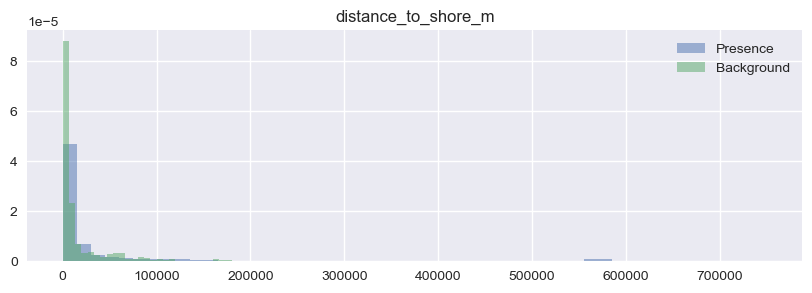

In [120]:
# Check out histograms of variables
PREDICTOR_COLS = [
    "distance_to_shore_m",
    # "mean_sst",
    # TODO - add in all the ones we can get!
]

for predictor in PREDICTOR_COLS:
    plt.figure(figsize=(10, 3))
    plt.hist(presence_gdf_filtered[predictor], bins=50, alpha=0.5, label="Presence", density=True)
    plt.hist(background_gdf_filtered[predictor], bins=50, alpha=0.5, label="Background", density=True)
    plt.title(predictor)
    plt.legend()
    plt.show()

### 9. Modelling with Spatial Cross Validation
- Create spatial folds for all points
- Fit XGBoost model across all folds
- Basic threshold optimisation - use small validation set to find optimal threshold, then evaluate using that on the left out set
- Obtain precision, recall and f1_score for all folds - to evaluate further in the next section

#### 9.1 Prepare Data and Create Spatial Fold IDs
- Binary classification problem
- The spatial fold IDs are based on points being at least 50km away from each other to ensure there isn't locality bias in evaluation

In [121]:
NUM_FOLDS = 5

In [122]:
def prepare_data_for_modelling(presence_gdf, background_gdf, min_distance_between_folds_m=50000):
    presence_gdf["label"] = 1
    background_gdf["label"] = 0
    presence_gdf = presence_gdf.to_crs(epsg=4326)
    background_gdf = background_gdf.to_crs(epsg=4326)
    full_gdf = pd.concat([presence_gdf, background_gdf], ignore_index=True).reset_index(drop=True)
    X = full_gdf[PREDICTOR_COLS].values
    y = full_gdf["label"].values
    return full_gdf, X, y

def create_spatial_folds(full_gdf, num_folds=3, min_distance_between_folds_m=50000):
    full_gdf = full_gdf.to_crs(epsg=3857)
    coords = np.vstack([full_gdf.geometry.x, full_gdf.geometry.y]).T
    tree = cKDTree(coords)
    fold_ids = -1 * np.ones(len(full_gdf), dtype=int)
    
    current_fold = 0
    for i in range(len(full_gdf)):
        if fold_ids[i] == -1:
            fold_ids[i] = current_fold
            neighbors = tree.query_ball_point(coords[i], r=min_distance_between_folds_m)
            neighbors.remove(i)
            fold_ids[neighbors] = current_fold
            current_fold = (current_fold + 1) % num_folds  # Cycle through - i.e. each fold will be distributed across the map
    full_gdf["fold_id"] = fold_ids
    return full_gdf, full_gdf["fold_id"].values

In [123]:
full_gdf, X, y = prepare_data_for_modelling(presence_gdf_filtered, background_gdf_filtered)
full_gdf, fold_ids = create_spatial_folds(full_gdf, num_folds=NUM_FOLDS)
# Ensure decent representation of points in each fold
full_gdf[full_gdf["label"] == 0]["fold_id"].value_counts().sort_index(), full_gdf[full_gdf["label"] == 1]["fold_id"].value_counts().sort_index()

(fold_id
 0    4923
 1    2215
 2    3258
 3    5222
 4    2962
 Name: count, dtype: int64,
 fold_id
 0    311
 1    365
 2    602
 3    555
 4    282
 Name: count, dtype: int64)

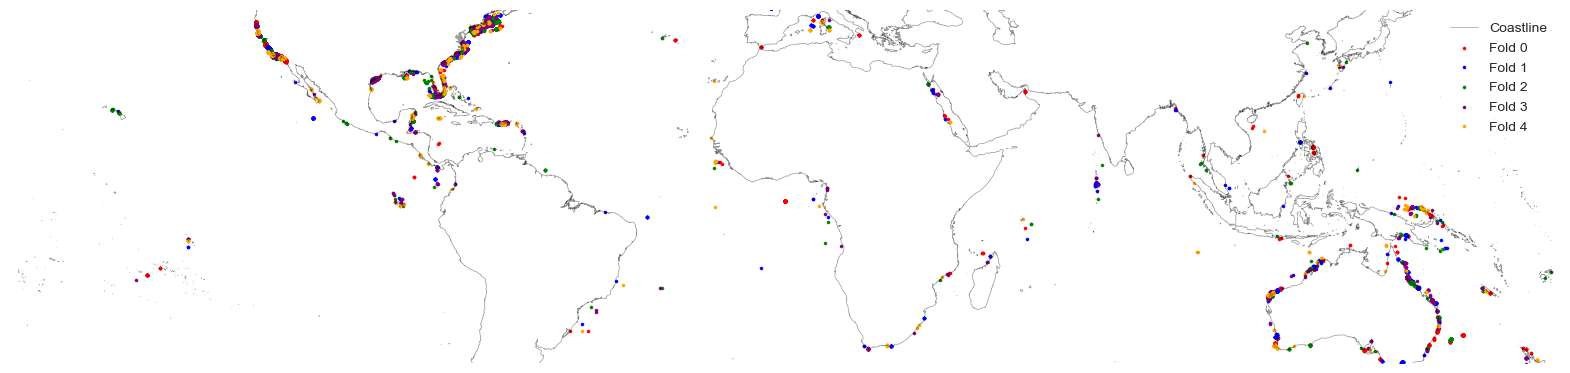

In [124]:
# Visualise folds
full_gdf = full_gdf.to_crs(epsg=4326)
visualise_data_on_map(coastline, 
                      [full_gdf[full_gdf["fold_id"] == i] for i in range(NUM_FOLDS)], 
                      ["red", "blue", "green", "purple", "orange"],
                      [f"Fold {i}" for i in range(NUM_FOLDS)],
                      coastline_alpha=0.4, plot_bounding_box=False, limit_to_bounding_box=True)

#### 9.2 Train and Evaluate XGBoost Model with Spatial CV
- Need lots of regulation due to very small presence data size
- Evaluation is AUCPR due to heavy class imbalance - i.e. we are predicting a rare class
  - Also due to class imbalance I have set weights per class to combat this
- Trying to reduce overfitting via early stopping, max_depth, row + column sampling per tree, L2 norm, L1 norm
- Generalisation typically improves if using a small learning rate with more trees
- n_jobs just there to speed up training

In [125]:
def split_train_val_test(X, y, fold_ids, test_fold_id):
    fold_mask = (fold_ids == test_fold_id)
    X_test, y_test = X[fold_mask], y[fold_mask]
    X_train_val, y_train_val = X[~fold_mask], y[~fold_mask]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=0, stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def calculate_class_weights(y_train):
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    positive_weight = n_neg / max(n_pos, 1)
    return positive_weight


def train_xgboost_model(X_train, y_train, X_val, y_val, positive_weight):
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=2000,
        max_depth=5,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        scale_pos_weight=positive_weight,
        n_jobs=4,
        early_stopping_rounds=50,
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return model


def find_optimal_threshold(model, X_val, y_val):
    """Use F1 Score weighted by class to find optimal threshold."""
    y_probs = model.predict_proba(X_val)[:, 1]
    weights = np.where(y_val == 1, 0.5 / (y_val == 1).sum(), 0.5 / (y_val == 0).sum())
    precision, recall, thresholds = precision_recall_curve(y_val, y_probs, sample_weight=weights)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_idx - 1] if best_idx > 0 else 0.5
    return best_threshold


def evaluate_model(model, X_test, y_test, threshold):
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)
    weights = np.where(y_test == 1, 0.5 / (y_test == 1).sum(), 0.5 / (y_test == 0).sum())
    precision = precision_score(y_test, y_pred, sample_weight=weights)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, sample_weight=weights)
    return precision, recall, f1

In [126]:
precisions, recalls, f1_scores, best_thresholds = [], [], [], []
for i in range(NUM_FOLDS):
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, fold_ids, test_fold_id=i)
    pos_weight = calculate_class_weights(y_train)
    xgbm = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
    best_threshold = find_optimal_threshold(xgbm, X_val, y_val)
    precision, recall, f1 = evaluate_model(xgbm, X_test, y_test, best_threshold)
    print("Stopped after {} trees".format(xgbm.best_iteration))

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    best_thresholds.append(best_threshold)

Stopped after 566 trees
Stopped after 590 trees
Stopped after 237 trees
Stopped after 443 trees
Stopped after 638 trees


In [127]:
for i in range(NUM_FOLDS):
    print(
        f"Fold {i+1}: P={precisions[i]:.3f}, R={recalls[i]:.3f}, F1={f1_scores[i]:.3f} (thr={best_thresholds[i]:.8f})"
    )

Fold 1: P=0.496, R=0.656, F1=0.565 (thr=0.38999027)
Fold 2: P=0.562, R=0.885, F1=0.688 (thr=0.30153057)
Fold 3: P=0.534, R=0.925, F1=0.677 (thr=0.37506330)
Fold 4: P=0.577, R=0.715, F1=0.639 (thr=0.40775591)
Fold 5: P=0.484, R=0.695, F1=0.570 (thr=0.37877154)


### 10. Evaluation, Final Model and Interpretation


In [128]:
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
print(f"Mean F1 Score: {mean_f1:.3f} ± {std_f1:.3f}")

Mean F1 Score: 0.628 ± 0.052


In [129]:
X_train, X_val, _, y_train, y_val, _ = split_train_val_test(
    X, y, fold_ids, test_fold_id=1000  # Not a real id, i.e. no test set
)
pos_weight = calculate_class_weights(y_train)
final_model = train_xgboost_model(X_train, y_train, X_val, y_val, pos_weight)
best_threshold = find_optimal_threshold(final_model, X_val, y_val)
print("Final model stopped after {} trees".format(final_model.best_iteration))

Final model stopped after 541 trees


In [130]:
importances = final_model.get_booster().get_score(importance_type="gain")
importance_df = {}
for i, var in enumerate(PREDICTOR_COLS):
    importance_df[var] = importances[f"f{i}"]
importance_df

{'distance_to_shore_m': 18.510099411010742}

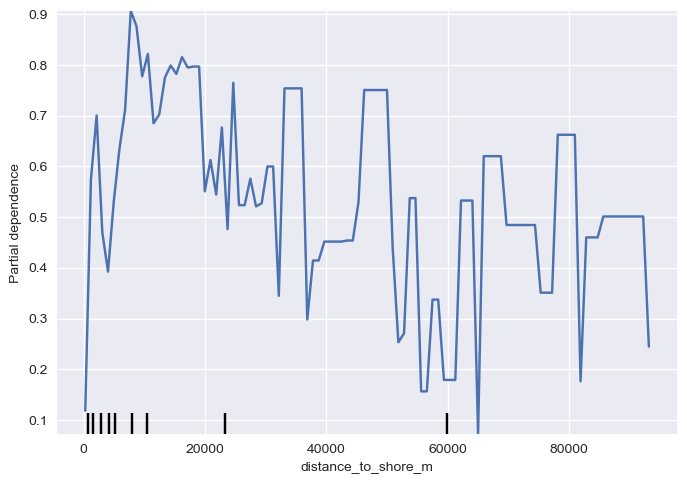

In [131]:
PartialDependenceDisplay.from_estimator(
    final_model,
    X_val,
    features=[i for i in range(len(PREDICTOR_COLS))],
    feature_names=PREDICTOR_COLS,
    kind="average",
)
plt.show()

### 11. Visualisation
- Map out the probability distribution in the accessible area for a given month+year!

In [ ]:
ii, jj = np.where(accessible_area_mask.astype(bool))
lat_arr = lats[ii]
lon_arr = lons[jj]

# The below I need to replace with the new environmental data we will use!
# bath_arr   = bath_ds["bathymetry_mean"].values[0][ii, jj]
# sst_mean   = mean_sst_ds["thetao_mean"].values[0][ii, jj]
# sst_range  = range_sst_ds["thetao_range"].values[0][ii, jj]
# sal_mean   = salinity_ds["so_mean"].values[0][ii, jj]
# chl_mean   = chloro_ds["chl_mean"].values[0][ii, jj]
# slope_arr  = slope_ds["slope"].values[0][ii, jj]
# X = np.column_stack([
#     bath_arr,
#     sst_mean,
#     sst_range,
#     sal_mean,
#     chl_mean,
#     slope_arr,
#     distance_to_shore_arr
# ])

valid = ~np.any(np.isnan(X), axis=1)
invalid = np.any(np.isnan(X), axis=1)
probs = final_model.predict_proba(X[valid])[:, 1]

predictions = np.zeros_like(accessible_area_mask, dtype=float) * np.nan
predictions[ii[valid], jj[valid]] = probs
predictions[ii[invalid], jj[invalid]] = np.nan

In [ ]:
visualise_data_on_map(coastline, [presence_gdf], ["red"], ["Observations"],
                      plot_bounding_box=False, limit_to_bounding_box=True, show_plot=False)
mesh = plt.gca().pcolormesh(
    lons, lats, predictions,
    cmap="cividis",
    label="Predicted Suitability"
)
plt.legend()
plt.show()

In [ ]:
# Next steps:
# - Get more environmental data, probably as averages
# - Map all environmental data to all points
# - Improve distance filters everywhere to account for earth curvature
# - Run the full pipeline, generate a model, and feed the predictions raster into the website
# -- Bonus, we can showcase how this prediction model changes with every month for a particular region and project it forwards too